In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prettypyplot as pplt
from chespex.optimization.gaussian_process_fix_noise import GaussianProcess
from gpytorch.constraints import Interval
from sklearn.neighbors import KDTree
from analysis_helper import *

pplt.use_style(true_black=True, sf=False)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams.update({"font.size": 9, "figure.dpi": 220, 'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})

figpath = Path()
linewidth = 3.40457  # Two column page in inch
linewidth_double = 7.05826  # One column page in inch

In [4]:
client = MongoClient("mongodb://localhost:27017")
database = client.get_database(f"molecules-4")

In [ ]:
molecules = load_molecules_list("molecules.list", default_level=0)
molecules['latent_space'] = molecules.apply(lambda row: load_molecule_latent_space(row), axis=1)
molecules.sample(6)

In [3]:
lengthscales = {}
for level in [0,1,2]:
    molecule_selection = molecules[molecules['level'] == level]
    gp = GaussianProcess(lengthscale_constraint=Interval(0.01, 10), noise=1.28e-3)
    gp.fit(np.array(molecule_selection["latent_space"].to_list()), molecule_selection["result"].to_numpy())
    lengthscales[level] = gp.lengthscale
    print(f'Level {level}: Lengthscale {gp.lengthscale}')

Level 0: Lengthscale 2.9620606899261475
Level 1: Lengthscale 1.2567218542099
Level 2: Lengthscale 0.7343690991401672


In [2]:
# Result from previous cell (to skip rerunning)
lengthscales = {0: 2.9620606899261475, 1: 1.2567218542099, 2: 0.7343690991401672}

In [3]:
molecule_numbers = {}
for level in [0,1,2]:
    print(f"Level {level}", end=' ')
    collection = database.get_collection(f"level-{level}")
    cursor = collection.find({},{'latent_space': 1})
    latent_space = np.array([e['latent_space'] for e in cursor])
    print('- loaded latent space', end=' ')
    tree = KDTree(latent_space, leaf_size=50)
    print('- constructed tree')
    mean_counts = []
    for _ in range(10):
        test_points_indices = np.random.choice(np.arange(len(latent_space)), size=30000, replace=False)
        test_points = latent_space[test_points_indices]
        counts = tree.query_radius(test_points, r=lengthscales[level] * 0.5, count_only=True)
        print(f"    {counts.mean()}")
        mean_counts.append(counts.mean())
    molecule_numbers[level] = np.mean(mean_counts)
    print(f'Mean: {np.mean(mean_counts)} +/- {np.std(mean_counts)}')

Level 0 - loaded latent space - constructed tree
    247.61236666666667
    250.5137
    250.12116666666665
    247.00243333333333
    248.55983333333333
    247.41143333333332
    247.7144
    251.43933333333334
    248.73836666666668
    247.1632
Mean: 248.6276233333333 +/- 1.47784129331716
- loaded latent space - constructed tree
    23.0165
    23.0934
    23.1687
    23.058633333333333
    22.988966666666666
    23.194633333333332
    22.9704
    23.155966666666668
    22.999166666666667
    23.120533333333334
Mean: 23.07669 +/- 0.07733977997555101
- loaded latent space - constructed tree
    36.26063333333333
    36.79096666666667
    36.207633333333334
    36.797066666666666
    37.293033333333334
    36.9223
    36.401466666666664
    36.41393333333333
    37.293166666666664
    37.43613333333333
Mean: 36.78163333333333 +/- 0.4303865652591347


In [3]:
# Result from previous cell (to skip rerunning)
molecule_numbers = {0: 248.627623333, 1: 23.07669, 2: 36.781633333}

Total molecules: [89960, 6742680, 136870880]
Low res. neighborhood sizes: 248.6, 18635.1, 378277.9
Medium res. neighborhood sizes: 23.1, 468.4
High res. neighborhood size: 36.8


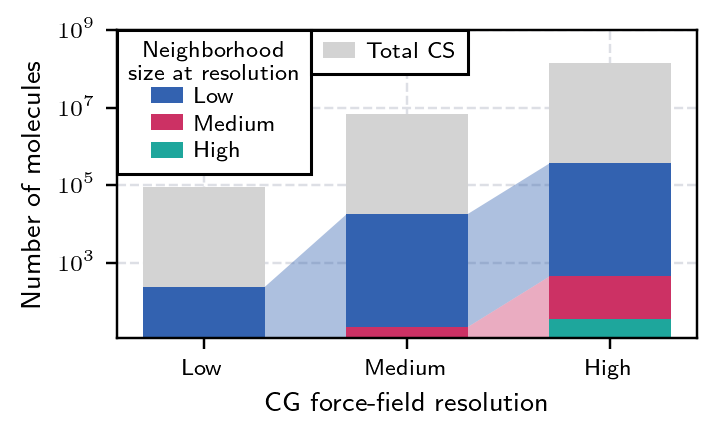

In [4]:
categories = ['Low', 'Medium', 'High']
total_molecules = [MOLECULE_NUMBERS[i] for i in range(3)]
low_res_neighborhood = [
    molecule_numbers[0],
    molecule_numbers[0] * MOLECULE_NUMBERS[1] / MOLECULE_NUMBERS[0],
    molecule_numbers[0] * MOLECULE_NUMBERS[2] / MOLECULE_NUMBERS[0]
]
medium_res_neighborhood = [
    molecule_numbers[1],
    molecule_numbers[1] * MOLECULE_NUMBERS[2]/ MOLECULE_NUMBERS[1]
]
fig, ax = plt.subplots(figsize=(linewidth,2))
bar_width = 0.6
th = ax.bar(categories, total_molecules, label='Total', width=bar_width, color='lightgray')
print(f'Total molecules: {total_molecules}')
lh = ax.bar(categories, low_res_neighborhood, width=bar_width, color=colors[0])
ax.fill_between(
    [bar_width/2.03,1-bar_width/2],[12,12], [low_res_neighborhood[0],low_res_neighborhood[1]],
    alpha=0.4, color=colors[0], linewidth=0)
print(f'Low res. neighborhood sizes: {", ".join([f"{k:.1f}" for k in low_res_neighborhood])}')
mh = ax.bar(categories[1:], medium_res_neighborhood, width=bar_width, color=colors[1])
ax.fill_between(
    [1+bar_width/2.03,2-bar_width/2],
    [medium_res_neighborhood[0],medium_res_neighborhood[1]],
    [low_res_neighborhood[1],low_res_neighborhood[2]],
    alpha=0.4, color=colors[0], linewidth=0)
ax.fill_between(
    [1+bar_width/2.03,2-bar_width/2],
    [12,12],
    [medium_res_neighborhood[0],medium_res_neighborhood[1]],
    alpha=0.4, color=colors[1], linewidth=0)
print(f'Medium res. neighborhood sizes: {", ".join([f"{k:.1f}" for k in medium_res_neighborhood])}')
hh = ax.bar(categories[2:], [molecule_numbers[2]], width=bar_width, color=colors[2])
print(f'High res. neighborhood size: {molecule_numbers[2]:.1f}')
# Labels and legend
ax.set(ylabel="Number of molecules", xlabel='CG force-field resolution', ylim=(12,1e9), yscale='log')
l1 = ax.legend([lh,mh,hh],['Low','Medium','High'], labelspacing = 0.3, bbox_to_anchor=(0.0, 0.998),
               title=r'\begin{center}Neighborhood\\\vspace{-0.7mm}size at resolution\end{center}', loc='upper left')
ax.legend([th],[r'Total CS'], loc='upper center', bbox_to_anchor=(0.470,0.998))
ax.add_artist(l1)
plt.savefig(figpath / 'neighborhood-sizes.pdf')
plt.show()